In [1]:
# Data handling
import os
import pandas as pd
import numpy as np
import pyarrow.parquet as pq

# Date and time manipulation
from datetime import timedelta

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm


# Machine learning
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# XGBoost
import xgboost as xgb

# Utilities
import itertools

import sys
sys.path.append('/projectnb/peaclab-mon/boztop/resource-allocation/python_scripts')

from ml_model_training import train_xgboost
from kmeans_clustering import cluster_create_sub_dataframes
from plot_functions import plot_everything
from feature_selection import (
    xgboost_feature_selection, 
    random_forest_feature_importance, 
    correlation_feature_selection
)



In [2]:
directory = '/projectnb/peaclab-mon/boztop/resource-allocation/datasets/m100/21_12_job_table/metric=job_info_marconi100/a_0.parquet'

In [3]:
job_table_df = pd.read_parquet(directory)

In [4]:
def time_limit_to_seconds(time_limit_str):
    if '-' in time_limit_str:
        days, time_part = time_limit_str.split('-')
        time_parts = time_part.split(':')
        
        if len(time_parts) == 3:
            hours, minutes, seconds = map(int, time_parts)
        elif len(time_parts) == 2:
            hours, minutes = map(int, time_parts)
            seconds = 0
        else:
            raise ValueError(f"Invalid time format: {time_limit_str}")
        
        total_seconds = int(days) * 86400 + hours * 3600 + minutes * 60 + seconds
    else:
        time_parts = time_limit_str.split(':')
        
        if len(time_parts) == 3:
            hours, minutes, seconds = map(int, time_parts)
        elif len(time_parts) == 2:
            hours, minutes = map(int, time_parts)
            seconds = 0
        else:
            raise ValueError(f"Invalid time format: {time_limit_str}")
        
        total_seconds = hours * 3600 + minutes * 60 + seconds
    
    return total_seconds


In [5]:
job_table_df['submit_time'] = pd.to_datetime(job_table_df['submit_time'], format='%Y:%m:%d %H')
job_table_df['start_time'] = pd.to_datetime(job_table_df['start_time'], format='%Y:%m:%d %H')
job_table_df['end_time'] = pd.to_datetime(job_table_df['end_time'], format='%Y:%m:%d %H')

job_table_df['wait_time'] = (job_table_df['start_time'] - job_table_df['submit_time'])
job_table_df['execution_time'] = (job_table_df['end_time'] - job_table_df['start_time'])

job_table_df['wait_time'] = job_table_df['wait_time'].dt.total_seconds()
job_table_df['execution_time'] = job_table_df['execution_time'].dt.total_seconds()

job_table_df['time_limit_sec'] = job_table_df['time_limit_str'].apply(time_limit_to_seconds)


In [6]:
# --- LET'S MAKE SOME OBSERVATIONS! ---

print(f"Total number of jobs in the dataset: {job_table_df.shape[0]}")

success_df = job_table_df[job_table_df['job_state'] == 'COMPLETED']
print(f"Total number of successful jobs in the dataset: {success_df.shape[0]}")


print(f"Total number of timestamps in the dataset: {job_table_df['submit_time'].nunique()}")
print(f"Number of unique users: {job_table_df['user_id'].nunique()}")
  

Total number of jobs in the dataset: 130372
Total number of successful jobs in the dataset: 79173
Total number of timestamps in the dataset: 46197
Number of unique users: 456


In [7]:
cleaned_df = success_df[['array_job_id','cpus_alloc_layout',
        'end_time', 'group_id', 'job_id',  'nodes',   'num_cpus', 'num_nodes',
       'partition', 'priority', 'qos', 'start_time', 'submit_time', 'time_limit_sec','user_id', 'wait_time', 'execution_time']]

cleaned_df = cleaned_df.sort_values(by=['start_time']).reset_index(drop=True)

cleaned_df


'''
timestamp: end time
user_id and job_id match!
'''


'\ntimestamp: end time\nuser_id and job_id match!\n'

In [8]:
directory = '/projectnb/peaclab-mon/boztop/resource-allocation/datasets/m100/21_12_slurm/metric=num_nodes/a_0.parquet'
num_nodes_df = pd.read_parquet(directory)
num_nodes_df = num_nodes_df.sort_values(by=['partition', 'timestamp']).reset_index(drop=True)

directory = '/projectnb/peaclab-mon/boztop/resource-allocation/datasets/m100/21_12_slurm/metric=job_id/a_0.parquet'
job_id_df = pd.read_parquet(directory)
job_id_df = job_id_df.sort_values(by=['partition', 'timestamp']).reset_index(drop=True)



# Demonstration of time limit request vs queue time

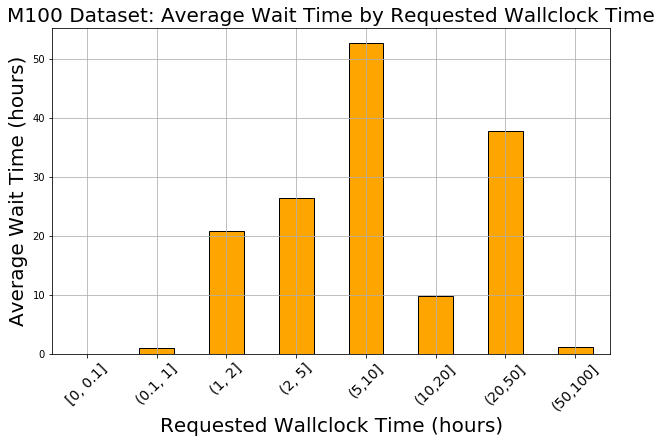

In [9]:
# Demonstrating the queue wait time increases with increasing wait time

bins = [0, 0.1, 1, 2, 5, 10, 20, 50, 100]
labels = ['[0, 0.1]', '(0.1, 1]', '(1, 2]', '(2, 5]', '(5,10]', '(10,20]','(20,50]','(50,100]']

cleaned_df['wallclock_req_hour'] = cleaned_df['time_limit_sec'] / 3600
cleaned_df['wait_time_hour'] = cleaned_df['wait_time'] / 3600


cleaned_df['wallclock_category'] = pd.cut(cleaned_df['wallclock_req_hour'], bins=bins, labels=labels)

wait_time_means = cleaned_df.groupby('wallclock_category')['wait_time_hour'].mean()

plt.figure(figsize=(10, 6))
wait_time_means.plot(kind='bar', color='orange', edgecolor='black')

plt.xlabel('Requested Wallclock Time (hours)', fontsize=20)
plt.ylabel('Average Wait Time (hours)', fontsize=20)
plt.title('M100 Dataset: Average Wait Time by Requested Wallclock Time', fontsize=20)
plt.grid(True)

plt.xticks(rotation=45)
plt.xticks(fontsize=14)
plt.show()




# Execution Time Prediction Experiment


In [10]:
cleaned_df.columns

Index(['array_job_id', 'cpus_alloc_layout', 'end_time', 'group_id', 'job_id',
       'nodes', 'num_cpus', 'num_nodes', 'partition', 'priority', 'qos',
       'start_time', 'submit_time', 'time_limit_sec', 'user_id', 'wait_time',
       'execution_time', 'wallclock_req_hour', 'wait_time_hour',
       'wallclock_category'],
      dtype='object')

In [11]:
cleaned_df['partition'] = cleaned_df['partition'].astype(int)
cleaned_df['qos'] = cleaned_df['qos'].astype(int)

numerical_submission_features = ['array_job_id', 'group_id', 'job_id', 'partition', 'priority','qos', 'user_id','time_limit_sec']



In [12]:
def find_optimal_feature_set(df_success,features, pred_feature, title, xlabel):
    X = df_success[features]
    y = df_success[pred_feature]
    

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rmse_values = []
    combinations = []
    
    for r in range(4, 5):
        print(f'Iteration: {r}')
        for combo in itertools.combinations(features, r):
            print(f'Feature Combination: {list(combo)}')
            X_train_combo = X_train[list(combo)]
            X_test_combo = X_test[list(combo)]

            model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')
            model.fit(X_train_combo, y_train)

            y_pred = model.predict(X_test_combo)

            rmse = np.sqrt(mean_squared_error(y_test, y_pred))

            rmse_values.append(rmse)
            combinations.append(', '.join(combo))
        
    sorted_indices = np.argsort(rmse_values)[::-1]
    sorted_rmse_values = np.array(rmse_values)[sorted_indices]
    sorted_combinations = np.array(combinations)[sorted_indices]

    norm = plt.Normalize(vmin=min(sorted_rmse_values), vmax=max(sorted_rmse_values))
    colors = cm.viridis(norm(sorted_rmse_values)) 

    plt.figure(figsize=(10, 6))
    bars = plt.barh(sorted_combinations, sorted_rmse_values, color=colors)

    cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'))
    cbar.set_label('RMSE', fontsize=12)

    plt.xlabel(f'{xlabel}', fontsize=14)
    plt.ylabel('Feature Combination', fontsize=14)
    plt.title(f'{title}', fontsize=16)
    plt.tight_layout()
    plt.show()


In [13]:
find_optimal_feature_set(cleaned_df,numerical_submission_features, 'execution_time', 'RMSE Values for Each Numerical Input Feature Combination', 'RMSE (sec)')



Iteration: 4
Feature Combination: ['array_job_id', 'group_id', 'job_id', 'partition']
Feature Combination: ['array_job_id', 'group_id', 'job_id', 'priority']


KeyboardInterrupt: 

In [14]:
rmse = np.sqrt(((cleaned_df['execution_time'] - cleaned_df['time_limit_sec']) ** 2).mean())

print(f"RMSE: {rmse}")


RMSE: 61646.038858006534


Train size (X_train): 63328
Test size (X_test): 15833
Train size (y_train): 63328
Test size (y_test): 15833


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


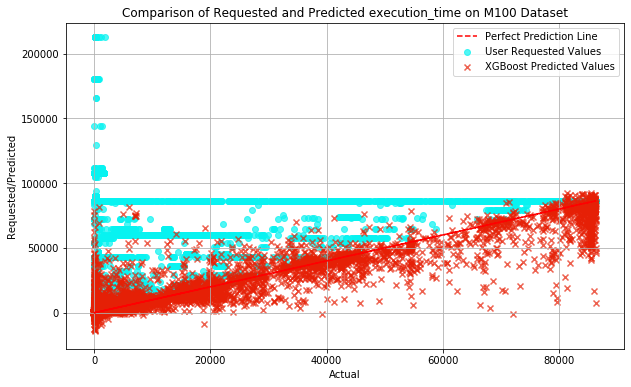

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


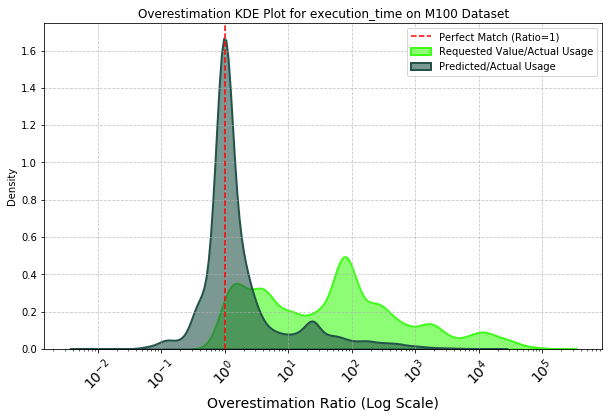

RMSE: 6340.5324
MAE: 2349.1241
R^2: 0.8960


In [15]:

rmse, mae, r2, y_test, y_pred, req_test = train_xgboost(cleaned_df, 'M100 Dataset', 'execution_time', ['array_job_id', 'group_id', 'job_id', 'partition', 'priority','qos', 'user_id','time_limit_sec'], 'time_limit_sec')

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")



Train size (X_train): 63328
Test size (X_test): 15833
Train size (y_train): 63328
Test size (y_test): 15833


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


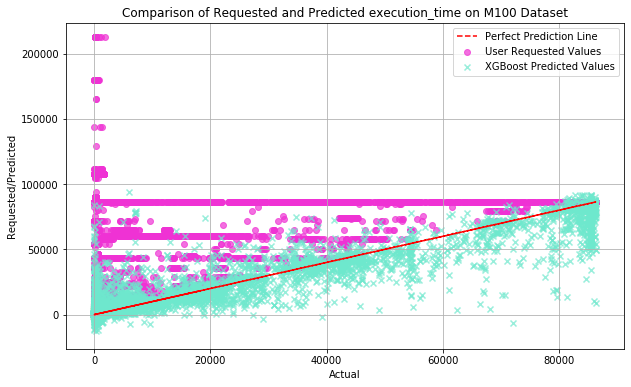

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


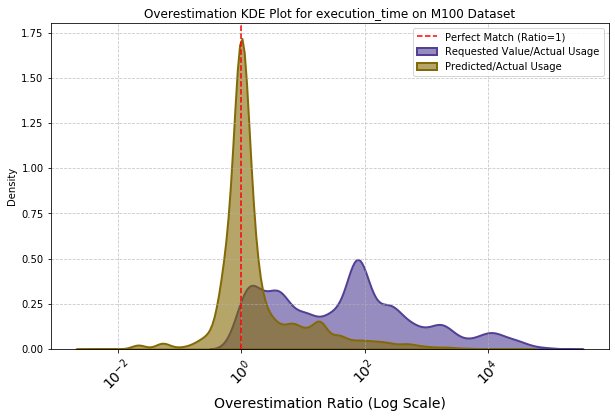

RMSE: 6278.6411
MAE: 2303.5370
R^2: 0.8980


In [16]:
rmse, mae, r2, y_test, y_pred, req_test = train_xgboost(cleaned_df, 'M100 Dataset', 'execution_time', ['group_id', 'priority', 'user_id','time_limit_sec'], 'time_limit_sec')

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")



/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


Processing cluster 1/10
Train size (X_train): 3987
Test size (X_test): 997
Train size (y_train): 3987
Test size (y_test): 997


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


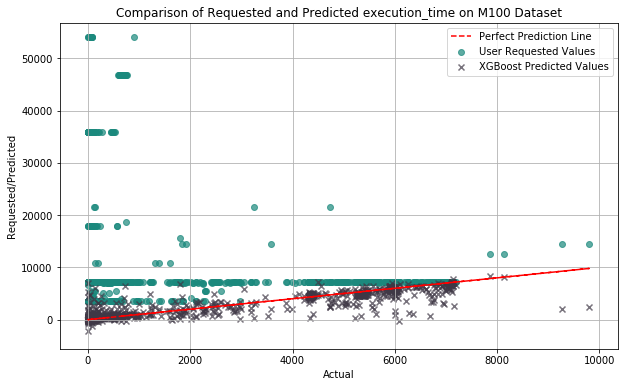

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


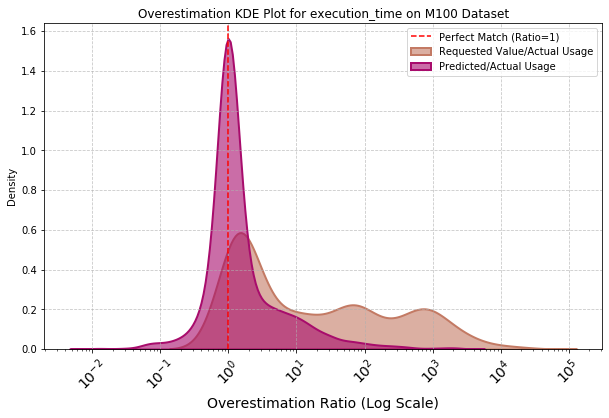

Processing cluster 2/10
Train size (X_train): 7409
Test size (X_test): 1853
Train size (y_train): 7409
Test size (y_test): 1853


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


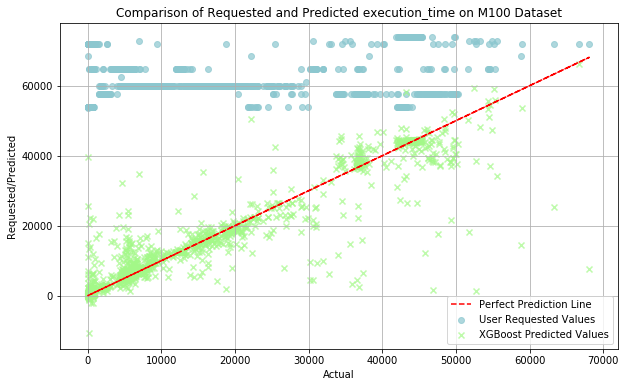

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


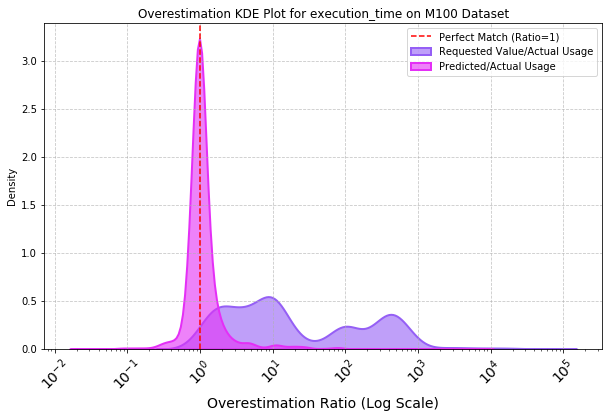

Processing cluster 3/10
Train size (X_train): 17722
Test size (X_test): 4431
Train size (y_train): 17722
Test size (y_test): 4431


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


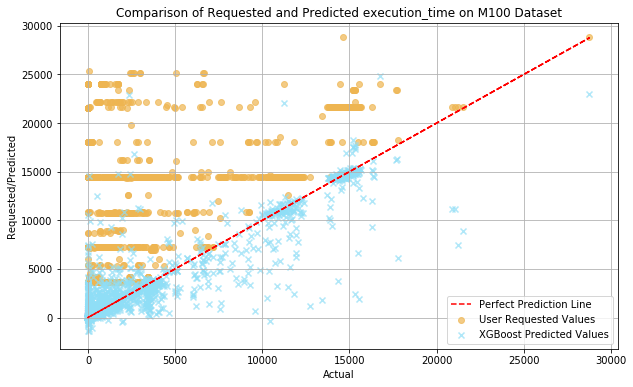

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


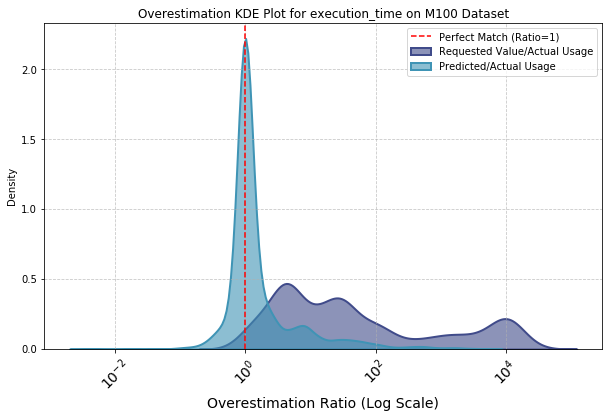

Processing cluster 4/10
Train size (X_train): 2031
Test size (X_test): 508
Train size (y_train): 2031
Test size (y_test): 508


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


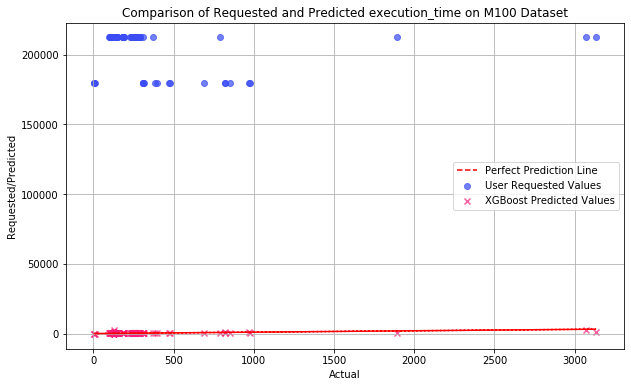

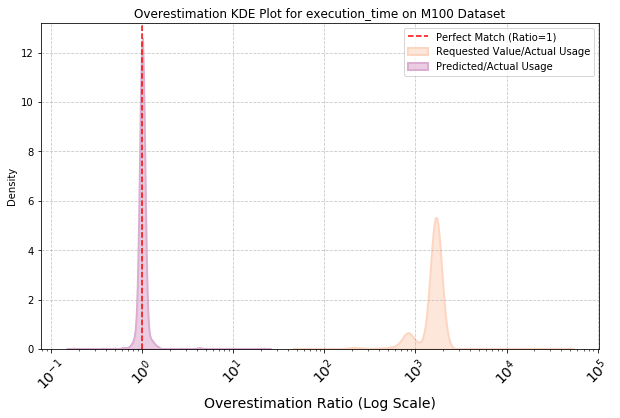

Processing cluster 5/10
Train size (X_train): 671
Test size (X_test): 168
Train size (y_train): 671
Test size (y_test): 168


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


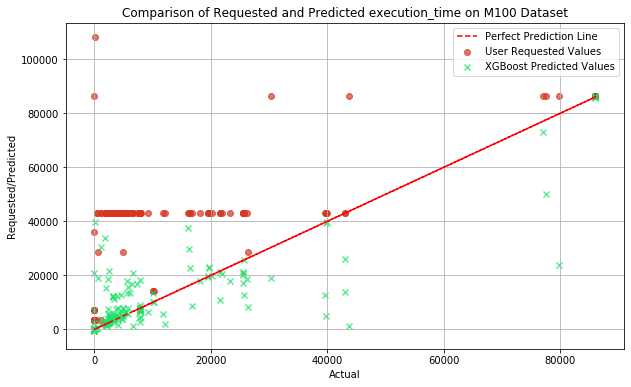

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


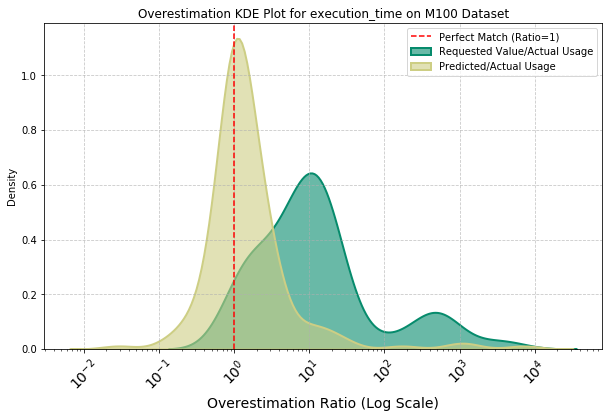

Processing cluster 6/10
Train size (X_train): 14873
Test size (X_test): 3719
Train size (y_train): 14873
Test size (y_test): 3719


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


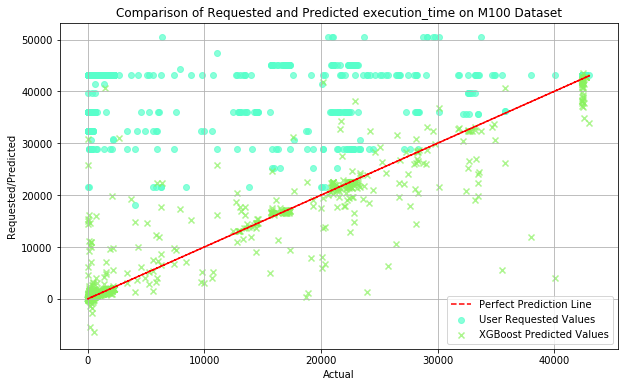

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


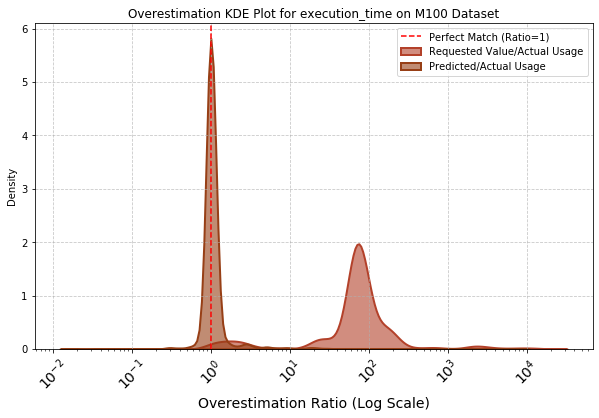

Processing cluster 7/10
Train size (X_train): 1792
Test size (X_test): 449
Train size (y_train): 1792
Test size (y_test): 449


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


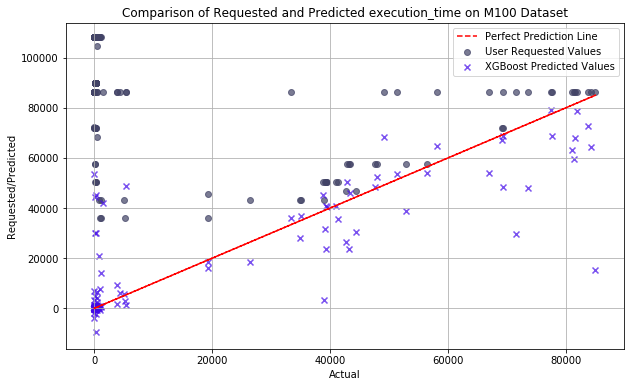

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


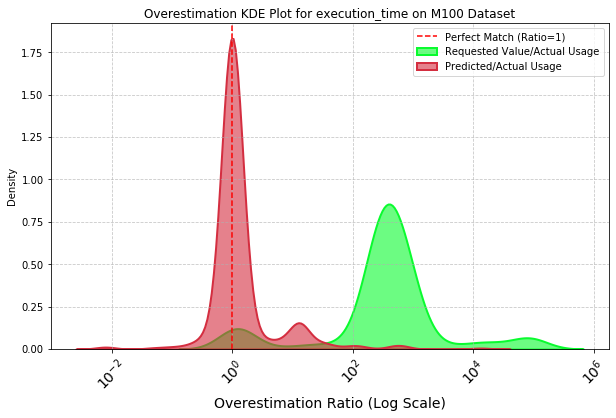

Processing cluster 8/10
Train size (X_train): 9966
Test size (X_test): 2492
Train size (y_train): 9966
Test size (y_test): 2492


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


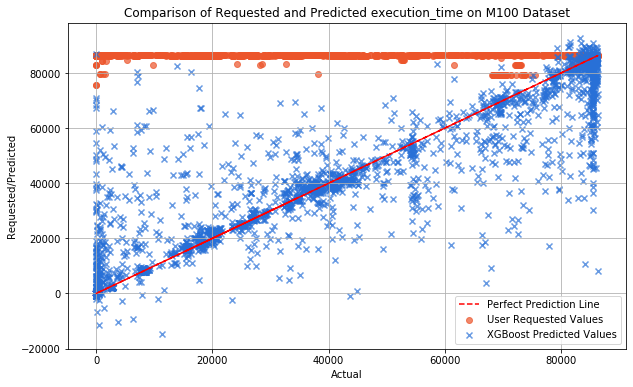

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


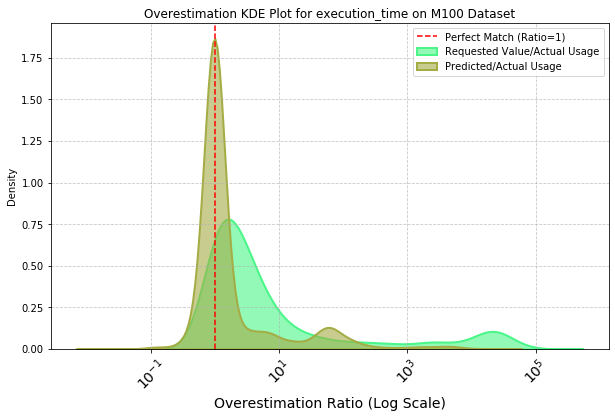

Processing cluster 9/10
Train size (X_train): 4857
Test size (X_test): 1215
Train size (y_train): 4857
Test size (y_test): 1215


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


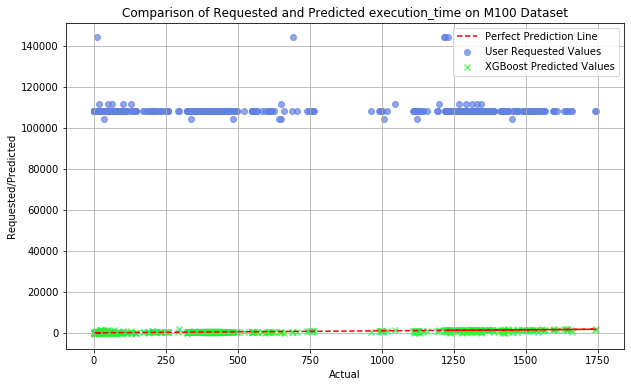

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


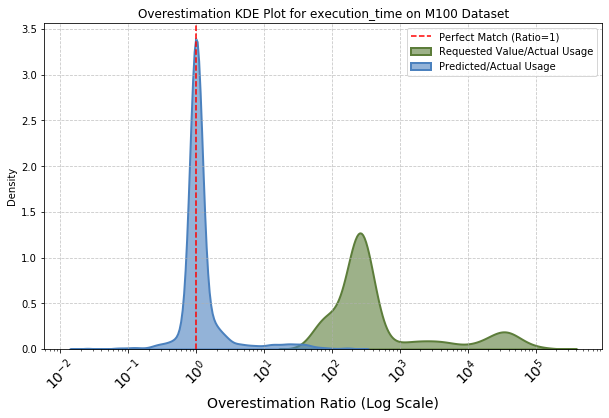

Processing cluster 10/10
Train size (X_train): 9
Test size (X_test): 3
Train size (y_train): 9
Test size (y_test): 3


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


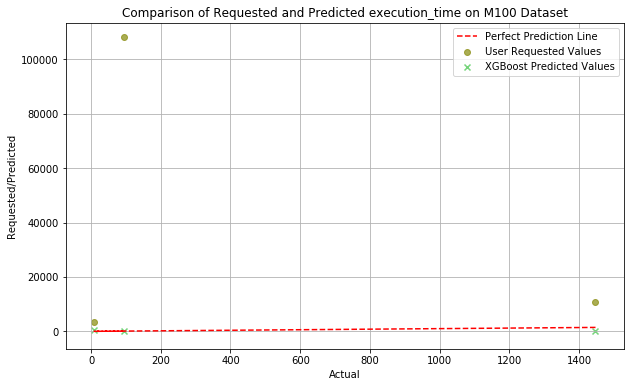

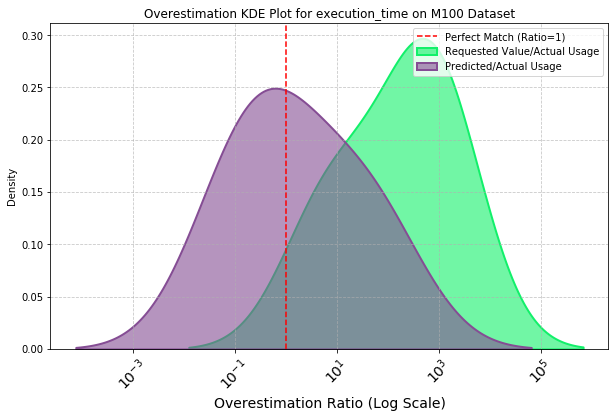

Average RMSE for Clustering: 4229.6732
Average MAE for Clustering: 1815.9372
Average R^2 for Clustering: 0.6430


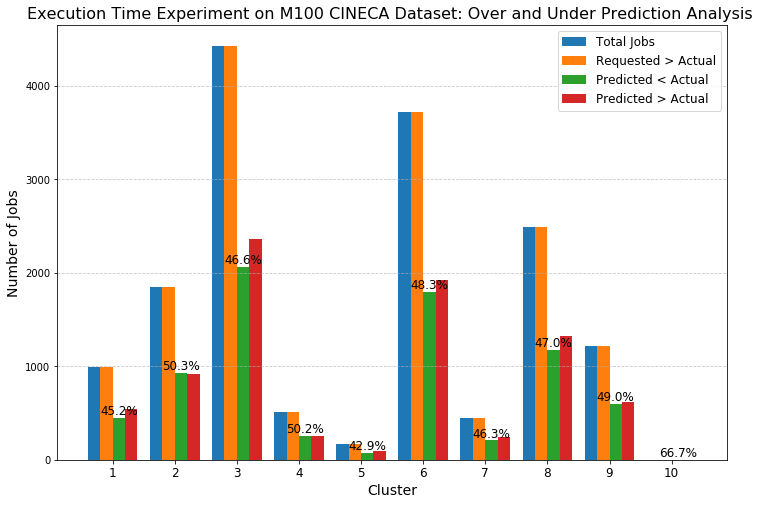

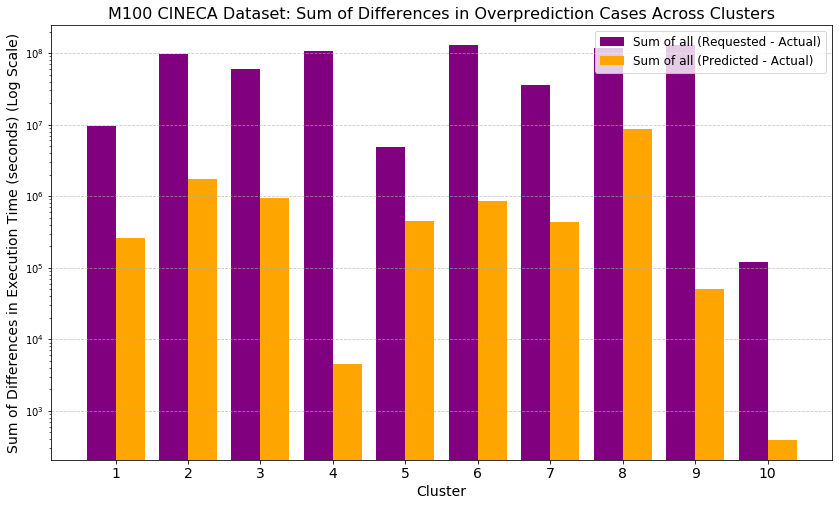

In [19]:
sub_dfs = cluster_create_sub_dataframes(cleaned_df,['group_id', 'priority', 'user_id','time_limit_sec'], ['execution_time'], 10)

rmse_list = []
mae_list = []
r2_list = []

metrics_data = []
overprediction_sums = []

for i, sub_df in enumerate(sub_dfs):
    print(f"Processing cluster {i+1}/{len(sub_dfs)}")
    
    rmse, mae, r2, y_test, y_pred, req_test= train_xgboost(sub_df, 'M100 Dataset', 'execution_time', ['group_id', 'priority', 'user_id','time_limit_sec'], 'time_limit_sec')
    
    if rmse is not None:
        rmse_list.append(rmse)
        mae_list.append(mae)
        r2_list.append(r2)

        total_jobs = len(y_test)
        requested_gt_target = (req_test > y_test).sum()
        predicted_lt_actual = (y_pred < y_test).sum()
        predicted_gt_actual = (y_pred > y_test).sum()

        op1 = y_pred > y_test
        op2 = req_test > y_test
        
        sum_predicted_minus_actual = (y_pred[op1] - y_test[op1]).sum()
        sum_requested_minus_actual = (req_test[op2] - y_test[op2]).sum()

        metrics_data.append([i + 1, total_jobs, requested_gt_target, predicted_lt_actual, predicted_gt_actual])
        overprediction_sums.append([sum_predicted_minus_actual, sum_requested_minus_actual])

        


rmse = np.mean(rmse_list)
print(f"Average RMSE for Clustering: {rmse:.4f}")
mae = np.mean(mae_list)
print(f"Average MAE for Clustering: {mae:.4f}")
r2 = np.mean(r2_list)
print(f"Average R^2 for Clustering: {r2:.4f}")


plot_everything(metrics_data, overprediction_sums, 
                'Execution Time Experiment on M100 CINECA Dataset: Over and Under Prediction Analysis ', 
                'M100 CINECA Dataset: Sum of Differences in Overprediction Cases Across Clusters',
                'Execution Time (seconds)')



# Analyzing SLURM plugin outputs

# CPU Information

In [37]:
directory = '/projectnb/peaclab-mon/boztop/resource-allocation/datasets/m100/21_12_slurm/metric=s21.cluster_cpu_util/a_0.parquet'
cpu_util_df = pd.read_parquet(directory)
cpu_util_df = cpu_util_df.sort_values(by=['partition', 'timestamp']).reset_index(drop=True)


directory = '/projectnb/peaclab-mon/boztop/resource-allocation/datasets/m100/21_12_slurm/metric=s21.totals.cpus_alloc/a_0.parquet'
cpu_alloc_df = pd.read_parquet(directory)
cpu_alloc_df = cpu_alloc_df.sort_values(by=['partition', 'timestamp']).reset_index(drop=True)


directory = '/projectnb/peaclab-mon/boztop/resource-allocation/datasets/m100/21_12_slurm/metric=s21.totals.cpus_config/a_0.parquet'
cpu_config_df = pd.read_parquet(directory)
cpu_config_df = cpu_config_df.sort_values(by=['partition', 'timestamp']).reset_index(drop=True)


In [38]:
def create_partition_df(cpu_config_df, cpu_alloc_df, cpu_util_df, partition):

    df_partition = cpu_config_df[cpu_config_df['partition'] == partition].merge(
        cpu_alloc_df[cpu_alloc_df['partition'] == partition], on='timestamp', suffixes=('_config', '_alloc')
    ).merge(
        cpu_util_df[cpu_util_df['partition'] == partition], on='timestamp', suffixes=('', '_util')
    )
    
    df_partition = df_partition[['timestamp', 'partition', 'value_config', 'value_alloc', 'value']]
    df_partition = df_partition.rename(columns={'value_config': 'cpu_config'})
    df_partition = df_partition.rename(columns={'value_alloc': 'cpu_alloc'})
    df_partition = df_partition.rename(columns={'value': 'cpu_util_percent'})
    df_partition['cpu_used'] = 0.01 * df_partition['cpu_alloc'] * df_partition['cpu_util_percent']
    
    return df_partition


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


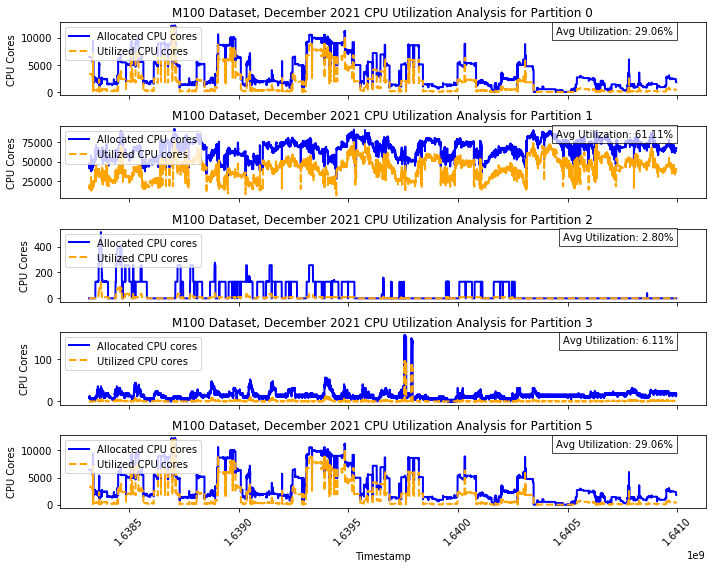

In [39]:
dataframes = [
    create_partition_df(cpu_config_df, cpu_alloc_df, cpu_util_df, '0'),
    create_partition_df(cpu_config_df, cpu_alloc_df, cpu_util_df, '1'),
    create_partition_df(cpu_config_df, cpu_alloc_df, cpu_util_df, '2'),
    create_partition_df(cpu_config_df, cpu_alloc_df, cpu_util_df, '3'),
    create_partition_df(cpu_config_df, cpu_alloc_df, cpu_util_df, '5')
]

partitions = ['0', '1', '2', '3', '5']
fig, axs = plt.subplots(len(partitions), 1, figsize=(10, 8), sharex=True)

for i, partition in enumerate(partitions):
    df = dataframes[i]
    
    timestamps = pd.to_datetime(df['timestamp']).astype(np.int64) // 10**9  # Convert to seconds
    cpu_config = np.array(df['cpu_config']).flatten()
    cpu_alloc = np.array(df['cpu_alloc']).flatten()
    cpu_used = np.array(df['cpu_used']).flatten()
    cpu_util_percent = df['cpu_util_percent'].values
    
    #axs[i].plot(timestamps, cpu_config, color='red', label='CPU Config', linestyle='-', linewidth=2)
    axs[i].plot(timestamps, cpu_alloc, color='blue', label='Allocated CPU cores', linestyle='-', linewidth=2)
    axs[i].plot(timestamps, cpu_used, color='orange', label='Utilized CPU cores', linestyle='--', linewidth=2)

    avg_utilization = cpu_util_percent.mean()
    axs[i].text(0.95, 0.95, f"Avg Utilization: {avg_utilization:.2f}%", 
                verticalalignment='top', horizontalalignment='right',
                transform=axs[i].transAxes, color='black', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
    
    axs[i].set_title(f"M100 Dataset, December 2021 CPU Utilization Analysis for Partition {partition}")
    axs[i].set_ylabel('CPU Cores')
    axs[i].legend(loc='upper left')

plt.xlabel('Timestamp')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()



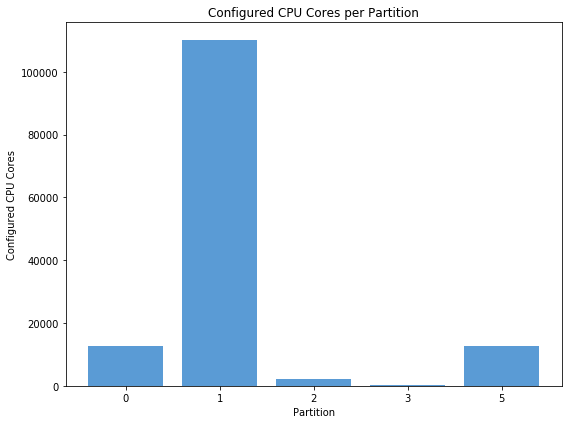

In [40]:
cpu_configs = [df['cpu_config'].unique()[0] for df in dataframes]

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(partitions, cpu_configs, color='#5A9BD5')  # Darker pastel blue
ax.set_title('Configured CPU Cores per Partition')
ax.set_ylabel('Configured CPU Cores')
ax.set_xlabel('Partition')

plt.tight_layout()
plt.show()

# GPU Information

In [41]:
directory = '/projectnb/peaclab-mon/boztop/resource-allocation/datasets/m100/21_12_slurm/metric=s21.cluster_gpu_util/a_0.parquet'
gpu_util_df = pd.read_parquet(directory)
gpu_util_df = gpu_util_df.sort_values(by=['partition', 'timestamp']).reset_index(drop=True)

min_value = gpu_util_df['value'].min()
max_value = gpu_util_df['value'].max()

print("Minimum value in 'value' column:", min_value)
print("Maximum value in 'value' column:", max_value)

directory = '/projectnb/peaclab-mon/boztop/resource-allocation/datasets/m100/21_12_slurm/metric=s21.totals.gpus_alloc/a_0.parquet'
gpu_alloc_df = pd.read_parquet(directory)
gpu_alloc_df = gpu_alloc_df.sort_values(by=['partition', 'timestamp']).reset_index(drop=True)

directory = '/projectnb/peaclab-mon/boztop/resource-allocation/datasets/m100/21_12_slurm/metric=s21.totals.gpus_config/a_0.parquet'
gpu_config_df = pd.read_parquet(directory)
gpu_config_df = gpu_config_df.sort_values(by=['partition', 'timestamp']).reset_index(drop=True)

gpu_util_df

Minimum value in 'value' column: 0.0
Maximum value in 'value' column: 100.0


,timestamp,value,partition
0,2021-12-01 00:00:00+00:00,84.693878,0
1,2021-12-01 00:00:10+00:00,84.693878,0
2,2021-12-01 00:00:20+00:00,84.693878,0
3,2021-12-01 00:00:30+00:00,84.693878,0
4,2021-12-01 00:00:40+00:00,84.693878,0
...,...,...,...
1320240,2021-12-31 23:59:10+00:00,17.346939,5
1320241,2021-12-31 23:59:20+00:00,17.346939,5
1320242,2021-12-31 23:59:30+00:00,17.346939,5
1320243,2021-12-31 23:59:40+00:00,17.346939,5


In [42]:
def gpu_create_partition_df(gpu_config_df, gpu_alloc_df, gpu_util_df, partition):
    df_partition = gpu_config_df[gpu_config_df['partition'] == partition].merge(
        gpu_alloc_df[gpu_alloc_df['partition'] == partition], on='timestamp', suffixes=('_config', '_alloc')
    ).merge(
        gpu_util_df[gpu_util_df['partition'] == partition], on='timestamp', suffixes=('', '_util')
    )
    
    df_partition = df_partition[['timestamp', 'partition', 'value_config', 'value_alloc', 'value']]
    
    df_partition = df_partition.rename(columns={
        'value_config': 'gpu_config',
        'value_alloc': 'gpu_alloc',
        'value': 'gpu_util_percent'
    })
    df_partition['gpu_used'] = df_partition['gpu_util_percent'] * df_partition['gpu_alloc'] * 0.01
    
    return df_partition


In [43]:
df_p = gpu_create_partition_df(gpu_config_df, gpu_alloc_df, gpu_util_df, '0')

df_p

,timestamp,partition,gpu_config,gpu_alloc,gpu_util_percent,gpu_used
0,2021-12-01 00:00:00+00:00,0,396,332,84.693878,281.183673
1,2021-12-01 00:00:10+00:00,0,396,332,84.693878,281.183673
2,2021-12-01 00:00:20+00:00,0,396,332,84.693878,281.183673
3,2021-12-01 00:00:30+00:00,0,396,332,84.693878,281.183673
4,2021-12-01 00:00:40+00:00,0,396,332,84.693878,281.183673
...,...,...,...,...,...,...
264044,2021-12-31 23:59:10+00:00,0,396,68,17.346939,11.795918
264045,2021-12-31 23:59:20+00:00,0,396,68,17.346939,11.795918
264046,2021-12-31 23:59:30+00:00,0,396,68,17.346939,11.795918
264047,2021-12-31 23:59:40+00:00,0,396,68,17.346939,11.795918


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


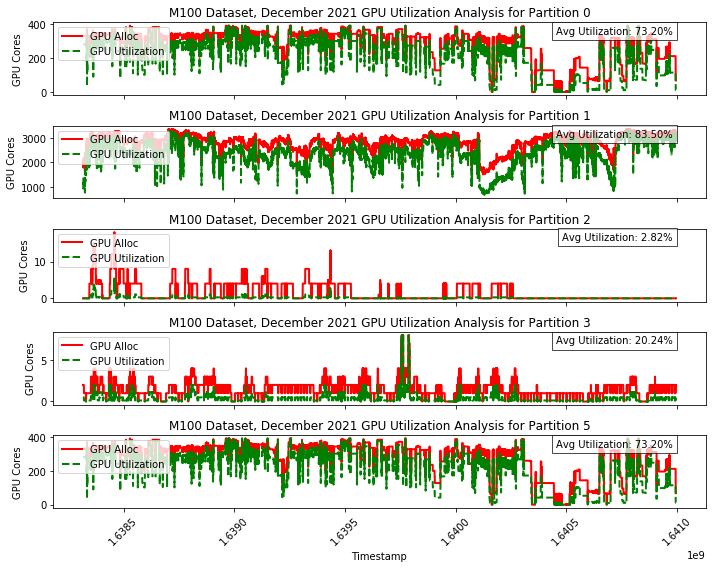

In [44]:

dataframes = [
    gpu_create_partition_df(gpu_config_df, gpu_alloc_df, gpu_util_df, '0'),
    gpu_create_partition_df(gpu_config_df, gpu_alloc_df, gpu_util_df, '1'),
    gpu_create_partition_df(gpu_config_df, gpu_alloc_df, gpu_util_df, '2'),
    gpu_create_partition_df(gpu_config_df, gpu_alloc_df, gpu_util_df, '3'),
    gpu_create_partition_df(gpu_config_df, gpu_alloc_df, gpu_util_df, '5')
]

partitions = ['0', '1', '2', '3', '5']
fig, axs = plt.subplots(len(partitions), 1, figsize=(10, 8), sharex=True)

for i, partition in enumerate(partitions):
    df = dataframes[i]
    
    timestamps = pd.to_datetime(df['timestamp']).astype(np.int64) // 10**9  # Convert to seconds
    gpu_alloc = np.array(df['gpu_alloc']).flatten()
    gpu_used = np.array(df['gpu_used']).flatten()
    
    #axs[i].plot(timestamps, gpu_req, color='blue', label='GPU Requested', linestyle='-', linewidth=2)
    axs[i].plot(timestamps, gpu_alloc, color='red', label='GPU Alloc', linestyle='-', linewidth=2)
    axs[i].plot(timestamps, gpu_used, color='green', label='GPU Utilization', linestyle='--', linewidth=2)

    avg_utilization_percent = df['gpu_util_percent'].mean()
    axs[i].text(0.95, 0.95, f"Avg Utilization: {avg_utilization_percent:.2f}%", 
                verticalalignment='top', horizontalalignment='right',
                transform=axs[i].transAxes, color='black', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
    
    
    axs[i].set_title(f"M100 Dataset, December 2021 GPU Utilization Analysis for Partition {partition}")
    axs[i].set_ylabel('GPU Cores')
    axs[i].legend(loc='upper left')

plt.xlabel('Timestamp')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()



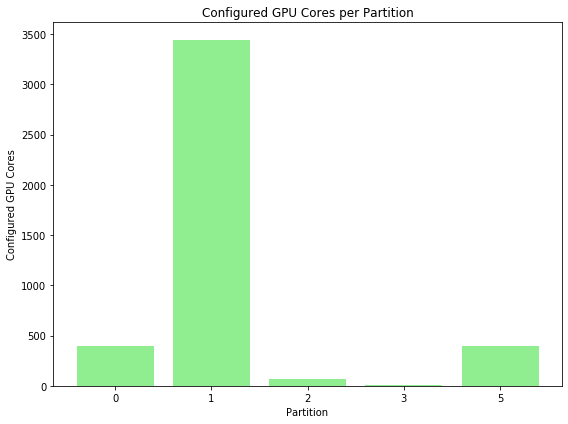

In [45]:
gpu_configs = [df['gpu_config'].unique()[0] for df in dataframes]

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(partitions, gpu_configs, color='#90EE90')  # Soft green
ax.set_title('Configured GPU Cores per Partition')
ax.set_ylabel('Configured GPU Cores')
ax.set_xlabel('Partition')

plt.tight_layout()
plt.show()

# Memory Information

In [46]:
directory = '/projectnb/peaclab-mon/boztop/resource-allocation/datasets/m100/21_12_slurm/metric=s21.cluster_mem_util/a_0.parquet'
mem_util_df = pd.read_parquet(directory)
mem_util_df = mem_util_df.sort_values(by=['partition', 'timestamp']).reset_index(drop=True)


directory = '/projectnb/peaclab-mon/boztop/resource-allocation/datasets/m100/21_12_slurm/metric=s21.totals.memory_alloc/a_0.parquet'
mem_alloc_df = pd.read_parquet(directory)
mem_alloc_df = mem_alloc_df.sort_values(by=['partition', 'timestamp']).reset_index(drop=True)


directory = '/projectnb/peaclab-mon/boztop/resource-allocation/datasets/m100/21_12_slurm/metric=s21.totals.memory_config/a_0.parquet'
mem_config_df = pd.read_parquet(directory)
mem_config_df = mem_config_df.sort_values(by=['partition', 'timestamp']).reset_index(drop=True)



In [47]:
def mem_create_partition_df(mem_config_df, mem_alloc_df, mem_util_df, partition):

    df_partition = mem_config_df[mem_config_df['partition'] == partition].merge(
        mem_alloc_df[mem_alloc_df['partition'] == partition], on='timestamp', suffixes=('_config', '_alloc')
    ).merge(
        mem_util_df[mem_util_df['partition'] == partition], on='timestamp', suffixes=('', '_util')
    )
    
    df_partition = df_partition[['timestamp', 'partition', 'value_config', 'value_alloc', 'value']]
    df_partition = df_partition.rename(columns={'value_config': 'mem_config'})
    df_partition = df_partition.rename(columns={'value_alloc': 'mem_alloc'})
    df_partition = df_partition.rename(columns={'value': 'mem_util_percent'})
    df_partition['mem_used'] = 0.01 * df_partition['mem_alloc'] * df_partition['mem_util_percent']
    
    return df_partition


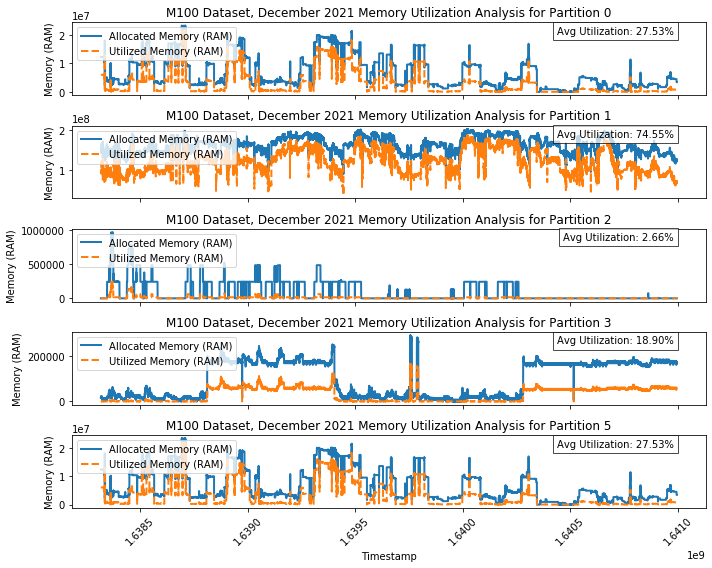

In [48]:
dataframes = [
    mem_create_partition_df(mem_config_df, mem_alloc_df, mem_util_df, '0'),
    mem_create_partition_df(mem_config_df, mem_alloc_df, mem_util_df, '1'),
    mem_create_partition_df(mem_config_df, mem_alloc_df, mem_util_df, '2'),
    mem_create_partition_df(mem_config_df, mem_alloc_df, mem_util_df, '3'),
    mem_create_partition_df(mem_config_df, mem_alloc_df, mem_util_df, '5')
]

partitions = ['0', '1', '2', '3', '5']
fig, axs = plt.subplots(len(partitions), 1, figsize=(10, 8), sharex=True)

for i, partition in enumerate(partitions):
    df = dataframes[i]
    
    timestamps = pd.to_datetime(df['timestamp']).astype(np.int64) // 10**9  # Convert to seconds
    mem_config = np.array(df['mem_config']).flatten()
    mem_alloc = np.array(df['mem_alloc']).flatten()
    mem_used = np.array(df['mem_used']).flatten()
    mem_util_percent = df['mem_util_percent'].values
    
    axs[i].plot(timestamps, mem_alloc, color='#1f77b4', label='Allocated Memory (RAM)', linestyle='-', linewidth=2)
    axs[i].plot(timestamps, mem_used, color='#ff7f0e', label='Utilized Memory (RAM)', linestyle='--', linewidth=2)

    avg_utilization = mem_util_percent.mean()
    axs[i].text(0.95, 0.95, f"Avg Utilization: {avg_utilization:.2f}%", 
                verticalalignment='top', horizontalalignment='right',
                transform=axs[i].transAxes, color='black', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
    
    axs[i].set_title(f"M100 Dataset, December 2021 Memory Utilization Analysis for Partition {partition}")
    axs[i].set_ylabel('Memory (RAM)')
    axs[i].legend(loc='upper left')

plt.xlabel('Timestamp')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()



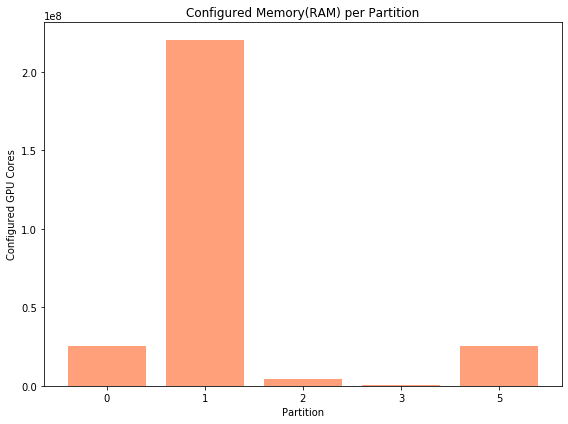

In [49]:
mem_configs = [df['mem_config'].unique()[0] for df in dataframes]

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(partitions, mem_configs, color='#FFA07A')  # Soft orange
ax.set_title('Configured Memory(RAM) per Partition')
ax.set_ylabel('Configured GPU Cores')
ax.set_xlabel('Partition')

plt.tight_layout()
plt.show()